### GIZ Initial Data Exploration
#### author: Emily Robitschek

Purpose: Before we build any model, we need to be able to take a look at the documents we have.

Some resources: 

#### papers mentioned in project proposal: 
https://medium.com/fiscalnoteworthy/citing-your-sources-79062248f468
https://www2.deloitte.com/us/en/insights/focus/cognitive-technologies/natural-language-processing-examples-in-government-data.html
https://documents1.worldbank.org/curated/en/634591516387264234/pdf/WPS8310.pdf

#### NLP related links: 
- https://spacy.io/usage/spacy-101
- https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
- https://arunm8489.medium.com/getting-started-with-natural-language-processing-6e593e349675
- https://towardsdatascience.com/natural-language-processing-pipeline-decoded-f97a4da5dbb7

### Import libraries

In [3]:
import os
import glob
import time
import json
import codecs
import re

import scipy
import numpy as np
import pandas as pd

#set up packages for processing data types and for NLP analysis
from collections import OrderedDict, Counter
import contractions
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from spacy import displacy

nlp = spacy.load('en_core_web_sm') #or the multi-language one: spacy.load('xx_ent_wiki_sm')

#from n_gram_correlation import NGramCorrelateSpacy

#graphing/visualization packages: 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

### Define helper functions for preprocessing

In [5]:
from datahelper import *
from nlppreprocess import *
from nlpanalysis import *
#from correlation import *
from textutils import importer

### Import data: Keywords from NDCs

In [6]:
#keywords (just for testing purposes - from the policy proposal from GIZ)
policy = ["policy", "integrate", "implement", "committee", "consultation"]
food = ["nutritions", "diets", "farm", "agriculture", "ecology"]

#keywords from json file
json_keywords_SA_file = '../ndc_keywords/ndc_south_africa.json'
keywords_SA_dict = None
with open(json_keywords_SA_file, 'r') as f: 
    keywords_SA_dict = json.load(f)
    
    
json_keywords_Ethiopia_file = '../ndc_keywords/ndc_ethiopia.json'
keywords_Ethiopia_dict = None
with open(json_keywords_Ethiopia_file, 'r') as f: 
    keywords_Ethiopia_dict = json.load(f)
    
print(keywords_SA_dict)
print(keywords_Ethiopia_dict)
#ndc_dict = make_filtered_tokens_from_ndc(keywords_SA_dict) #if want to use filtered, lemmatized tokens
ndc_dict = keywords_SA_dict
#ndc_dict = keywords_Ethiopia_dict

{'national adaption plan': ['national adaption plan', 'adaption plan', 'nap', 'sector plan', 'nccrp', 'vulnerable sector', 'geographic vulnerability'], 'climate change': ['climate change', 'adaption program', 'adaption projects', 'resilience', 'institutional capacity', 'response', 'budget reprioritisation', 'development', 'planner', 'regulator practitioners', 'geographical circumstances', 'land use scheme', 'authorisation system', 'spatial land use management act', 'spluma', 'paris agreement', 'climate agreement'], 'early warning': ['early warning', 'system', 'vulnerability', 'needs assessment', 'weather services', 'earth observation network', 'academic community']}
{'Adaptation to climate change': ['adaptation to climate change', 'climate change adaptation', 'increase resilience', 'reduce vulnerability', 'livelihoods', 'landscapes', 'droughts floods', 'food security', 'crop varieties', 'water scarcity', 'agroforestry', 'irrigation systems', 'irrigation system', 'biodiversity', 'geothe

In [7]:
# lets apply these functions to change the format of the NDC dictionary to a dataframe: 
def make_ndc_keyword_tidy_df_from_dict(key, col_group_name, ndc_dict):
    ndc_df = pd.DataFrame({'keyword': ndc_dict[key], 
                       col_group_name: key})
    return ndc_df

def stack_tidy_ndc_dfs(col_group_name, ndc_dict):
    ndc_df = pd.DataFrame()
    for key in ndc_dict.keys():
        ndc_df_add = make_ndc_keyword_tidy_df_from_dict(key, col_group_name, ndc_dict)
        ndc_df = pd.concat([ndc_df, ndc_df_add], axis=0)
    return ndc_df

col_group_name = 'NDC'
ndc_df = stack_tidy_ndc_dfs(col_group_name, ndc_dict)
ndc_df.head()



def return_window(ndc_word_index, tokens, size=100):
    """Returns a section of text around an NDC word, but also strips out some of the document information 
    because of the conversion of tokens to text and back. This window is used ot  
    so that non-overlapping windows are generated to look for the keyword topics"""
    lower_limit = ndc_word_index - size
    upper_limit = ndc_word_index + size
    token_idxs = [token.idx for token in tokens]
    window_token_list = []
    #print('The window is ', lower_limit, upper_limit)
    for index, idx in enumerate(token_idxs):
        if (idx >= lower_limit) and (idx <= upper_limit):
            window_token_list.append(tokens[index])
        else:
            pass
    text_for_windows = ' '.join(list(token.text for token in window_token_list))
    window_tokens = nlp(text_for_windows)
    return lower_limit, upper_limit, window_tokens


def make_ndc_idx_df_from_spans(ndc_keywords, labelled_doc): 
    """ndc_keywords is the ndc keyword dictionary and the labelled_doc is the one labelled with the spans of NDC keywords"""
    ndc_idx_df = pd.DataFrame()
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label) 
        ndc_idx_df_to_add = pd.DataFrame({'NDC': entity_reference,
                                          ('word'): [ent.text for ent in labelled_doc.ents if ent.label_ == entity_label],
                                          'word_index': [ent.start for ent in labelled_doc.ents if ent.label_ == entity_label]})
        ndc_idx_df = pd.concat([ndc_idx_df, ndc_idx_df_to_add], axis=0)
    return ndc_idx_df 

def label_ndc_spans(ndc_keywords, doc):
    """ndc_keywords is a dictionary, doc is the document text with nlp run on it that is the filtered but not lemmatized document text."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    entity_labels = []
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label)
        entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #print([(ent.text, ent.start, ent.label_) for ent in doc.ents])
    return entity_labels, doc

def label_ndc_spans_correlated(ndc_keywords, doc, span_length=2, corr_thresh=0.7):
    """ndc_keywords is a dictionary, doc is the document text with nlp run on it that is the filtered but not lemmatized document text."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    entity_labels = []
    ndc_dict_corr = dict()
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label)
        entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        n_gram_cor = NGramCorrelateSpacy(keywords, corr_thresh, entity_label)
        doc.ents = []
        n_gram_cor.correlate_spans(doc, span_length)
        print(len(doc.ents), len(set([ent.text for ent in list(doc.ents)])))
        unique_keywords_from_corr = list(set([ent.text for ent in list(doc.ents)]))
        ndc_dict_corr[entity_reference] = unique_keywords_from_corr
        patterns = [nlp(i) for i in unique_keywords_from_corr]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #print([(ent.text, ent.start, ent.label_) for ent in doc.ents])
    return entity_labels, ndc_dict_corr, doc

def find_patterns_df(pattern_list, text, topic_name):
    """This function takes in a list of keywords/terms and uses re exact matching to find them in the text 
    and returns a dataframe of their start locations, topics, and how many times they were found"""
    pattern_locations = []
    pattern_num = []
    for pattern in pattern_list:
        #print(pattern)
        re.findall(pattern, text, flags=0)
        #pattern_locations = [(m.start(0), m.end(0)) for m in re.finditer(pattern, text)] #if want start and end
        locations = [m.start(0) for m in re.finditer(pattern, text)]
        pattern_locations.append(locations)
        pattern_num.append(int(len(locations)))
    #print(pattern_locations)
        #if len(pattern_locations) > 0: 
        #    print(pattern, len(pattern_locations), pattern_locations)
    return pd.DataFrame({'sdg_topic': topic_name,
                         'sdg_keywords': pattern_list,
                         'sdg_keywords_num': pattern_num,
                         'sdg_keyword_locations': pattern_locations})

def make_sdg_df(sdg_list, sdg_ontology, text):
    df_sdg = pd.DataFrame()
    for sdg in list(sdg_list):
        sdg_keywords = list(sdg_ontology[sdg_ontology['clasification']==sdg]['keyword'])
        #print(sdg)
        df_sdg_to_add = find_patterns_df(sdg_keywords, text, topic_name=sdg)
        df_sdg = pd.concat([df_sdg, df_sdg_to_add])
    return df_sdg


def run_nlp_pipeline_no_lemma(doc_name, doc_path, ndc_dict, max_word_length):
    """This version of the pipeline employs the simple single word matching for finding NDC keywords, 
    and re based matching for the keyword topic keywords. """
    print(doc_name, doc_path)
    tokens, token_list, sentences = preprocess_doc(doc_path)
    filtered_tokens = filter_tokens(tokens)
    print('These are some of the filtered tokens: ', filtered_tokens[0:10])
    document_text = ' '.join([token.text for token in filtered_tokens if len(token.text)<=max_word_length])
    doc = nlp(document_text)
    ndc_labels, labelled_doc = label_ndc_spans(ndc_dict, doc)
    ndc_idx_df = make_ndc_idx_df_from_spans(ndc_dict, labelled_doc)
    ndc_idx_df.index = ndc_idx_df.NDC.copy()
    ndc_summary_df = ndc_idx_df['NDC'].value_counts().to_frame().rename(columns={"NDC": (doc_name)})
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
    doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": doc_name})
    doc_summary_df = pd.concat([doc_summary_sdg_df, ndc_summary_df]) #combine the SDG and NDC information into one df
    return tokens, token_list, sentences, filtered_tokens, document_text, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df #topic_frequencies, sentences


def run_nlp_pipeline_no_lemma_ndc_corr(doc_name, doc_path, ndc_dict, max_word_length):
    """This version of the pipeline incorporates the fuzzy search method that Johnathan wrote, 
    and re based matching for the keyword topic keywords."""
    print(doc_name, doc_path)
    tokens, token_list, sentences = preprocess_doc(doc_path)
    filtered_tokens = filter_tokens(tokens)
    print('These are some of the filtered tokens: ', filtered_tokens[0:10])
    document_text = ' '.join([token.text for token in filtered_tokens if len(token.text)<=max_word_length])
    doc = nlp(document_text)
    ndc_labels, ndc_dict_corr, labelled_doc = label_ndc_spans_correlated(ndc_dict, doc, span_length=2, corr_thresh=0.7)
    ndc_idx_df = make_ndc_idx_df_from_spans(ndc_dict_corr, labelled_doc)
    ndc_idx_df.index = ndc_idx_df.NDC.copy()
    ndc_summary_df = ndc_idx_df['NDC'].value_counts().to_frame().rename(columns={"NDC": (doc_name)})
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
    doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": doc_name})
    doc_summary_df = pd.concat([doc_summary_sdg_df, ndc_summary_df]) #combine the SDG and NDC information into one df
    return tokens, token_list, sentences, filtered_tokens, document_text, ndc_dict_corr, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df #topic_frequencies, sentences


### SDG and other topic keywords

In [8]:
sdg_ontology = pd.read_csv('../additional_resources/Ontology_final_modified.csv', sep=';')#, #skiprows=0)
sdg_list = ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
            'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 
            "mention_money"]

sdg_ontology.head(20)

,keyword,clasification
0,"""bop"" countries",SDG1
1,absolute poverty,SDG1
2,bellagio principles,SDG1
3,child nutritional status,SDG1
4,counting marginalised children,SDG1
5,dimensions of inequality,SDG1
6,diseases of poverty,SDG1
7,economic marginalisation,SDG1
8,education poverty,SDG1
9,educational poverty,SDG1


### Import data: Policy-related documents to analyze

In [9]:
#here is the general folder with the different types of policy documents
policy_doc_folder = '../test_resources'
policy_doc_folder = '../../selected_policy_tracking_docs/SouthAfrica/'
#policy_doc_folder = '../../selected_policy_tracking_docs/Ethiopia/'
#get df of docs
policy_doc_df = read_docs_to_df(policy_doc_folder)
print(len(policy_doc_df))
#policy_doc_df['policy_doc_name_clean'] = (policy_doc_df.index.apply(lambda x: x.split('.txt')[0].split('.pdf.ocr')[0]))
policy_doc_df.head()

53


,policy_doc_paths,policy_doc_name_clean
policy_doc_names,,
InSessionSpecialEditionBudget2021.txt,../../selected_policy_tracking_docs/SouthAfric...,InSessionSpecialEditionBudget2021
InSessionVol2Issue10.txt,../../selected_policy_tracking_docs/SouthAfric...,InSessionVol2Issue10
InSessionVol2Issue11.txt,../../selected_policy_tracking_docs/SouthAfric...,InSessionVol2Issue11
InSessionSpecialEdition2021.txt,../../selected_policy_tracking_docs/SouthAfric...,InSessionSpecialEdition2021
Climate_Change_Bill (2018).txt,../../selected_policy_tracking_docs/SouthAfric...,Climate_Change_Bill (2018)


### Preprocess data and run pipeline on a set of documents in series of folders

In [12]:
##lets take a look at the document from South Africa used in the example in the proposal first:
#doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.txt'
#doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

max_word_length=25
corpus_summary_df = pd.DataFrame()
count = 1
for i in range(0, 10): #len(policy_doc_df)
    doc_name = policy_doc_df.iloc[i]['policy_doc_name_clean']
    doc_path = policy_doc_df.iloc[i]['policy_doc_paths']
    tokens, token_list, sentences, filtered_tokens, document_text, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df = run_nlp_pipeline_no_lemma(doc_name, doc_path, ndc_dict, max_word_length) 
    print(ndc_idx_df.NDC.value_counts()) 
    if count == 1: 
        corpus_summary_df = doc_summary_df
        total = doc_summary_df[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
        count += 1
    else: 
        corpus_summary_df_for_merge = doc_summary_df
        total = doc_summary_df[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
        corpus_summary_df = corpus_summary_df.merge(corpus_summary_df_for_merge, how='outer', left_index=True, right_index=True)
        count += 1
corpus_summary_df.head()  

InSessionSpecialEditionBudget2021 ../../selected_policy_tracking_docs/SouthAfrica/InSession Parliament_s monthly magazine/TXT/InSessionSpecialEditionBudget2021.txt
These are some of the filtered tokens:  parliament republic south africa www.parliament.gov.za parliamentofrsa official newspaper parliament republic
climate change    18
early warning      1
Name: NDC, dtype: int64
InSessionSpecialEditionBudget2021 3474 697
InSessionVol2Issue10 ../../selected_policy_tracking_docs/SouthAfrica/InSession Parliament_s monthly magazine/TXT/InSessionVol2Issue10.txt
These are some of the filtered tokens:  parliament republic south africa www.parliament.gov.za parliamentofrsa official newspaper parliament republic
climate change    29
early warning      4
Name: NDC, dtype: int64
InSessionVol2Issue10 6194 1045
InSessionVol2Issue11 ../../selected_policy_tracking_docs/SouthAfrica/InSession Parliament_s monthly magazine/TXT/InSessionVol2Issue11.txt
These are some of the filtered tokens:  parliament rep

,InSessionSpecialEditionBudget2021,InSessionVol2Issue10,InSessionVol2Issue11,InSessionSpecialEdition2021,Climate_Change_Bill (2018),Executive Summary-National Development Plan 2030,NGP Framework for public release FINAL_1,South Africa_s Low Emission Development Strategy 2050_ocr,2nd National Biodiversity Strategy Action Plan 2015-2025,National Strategy for Sustainable Development and Action Plan 2011-14_ocr
SDG1,1.0,6.0,8.0,1.0,0.0,45.0,7.0,17,23,23.0
SDG10,13.0,36.0,19.0,10.0,25.0,235.0,173.0,175,358,310.0
SDG11,24.0,59.0,34.0,30.0,36.0,457.0,200.0,292,300,306.0
SDG12,3.0,7.0,1.0,0.0,0.0,22.0,16.0,131,71,103.0
SDG13,1.0,1.0,0.0,0.0,405.0,77.0,8.0,1186,137,220.0


### Can fill na values and export the corpus summary as a txt file

In [17]:
#example: 
corpus_summary_df = corpus_summary_df.fillna(0)
#output_name = '../../outputs/SA_spacy_matching_NDC_SDGs_df.txt'
#corpus_summary_df.to_csv('../../outputs/SouthAfrica_spacy_matching_NDC_SDGs_corpus_df.txt', sep='\t')

#test_df = pd.read_csv('../../outputs/SouthAfrica_spacy_matching_NDC_SDGs_corpus_df.txt', 
#                      index_col='Unnamed: 0', sep='\t')
#test_df.head()

### Make document level heatmaps to visualize data

In [19]:
#this normalization method has drawbacks as it depends on the prevalence of other categories which may not be desired.
#It would be better to normalize by number of filtered tokens or number of tokens per document.
normed_by_col_sum = corpus_summary_df.div(corpus_summary_df.sum(axis=0), axis=1).round(3) 
sorted_df = normed_by_col_sum.T.sort_values(by=['climate change'], ascending=False) #ndc south africa example
#sorted_df = normed_by_col_sum.T.sort_values(by=['Fairness, equity, ambition'], ascending=False) #ndc ethiopia example
normed_by_col_sum.head()

normed_by_col_sum_corr = corpus_summary_df.div(corpus_summary_df.sum(axis=0), axis=1).round(3)
sorted_df_corr = normed_by_col_sum_corr.T.sort_values(by=['climate change'], ascending=False)
#normed_by_col_sum_corr.head()

corpus_summary_df

,InSessionSpecialEditionBudget2021,InSessionVol2Issue10,InSessionVol2Issue11,InSessionSpecialEdition2021,Climate_Change_Bill (2018),Executive Summary-National Development Plan 2030,NGP Framework for public release FINAL_1,South Africa_s Low Emission Development Strategy 2050_ocr,2nd National Biodiversity Strategy Action Plan 2015-2025,National Strategy for Sustainable Development and Action Plan 2011-14_ocr
SDG1,1.0,6.0,8.0,1.0,0.0,45.0,7.0,17,23,23.0
SDG10,13.0,36.0,19.0,10.0,25.0,235.0,173.0,175,358,310.0
SDG11,24.0,59.0,34.0,30.0,36.0,457.0,200.0,292,300,306.0
SDG12,3.0,7.0,1.0,0.0,0.0,22.0,16.0,131,71,103.0
SDG13,1.0,1.0,0.0,0.0,405.0,77.0,8.0,1186,137,220.0
SDG14,1.0,2.0,3.0,4.0,6.0,62.0,34.0,51,242,129.0
SDG15,8.0,16.0,27.0,8.0,60.0,81.0,21.0,239,1600,190.0
SDG16,102.0,206.0,197.0,83.0,65.0,444.0,258.0,451,618,269.0
SDG17,47.0,95.0,65.0,59.0,4.0,56.0,60.0,118,229,112.0
SDG2,4.0,18.0,13.0,5.0,1.0,79.0,58.0,49,99,62.0


## Can look at multiple documents at once and see what topics are prevalent and prioritize them with a heatmp

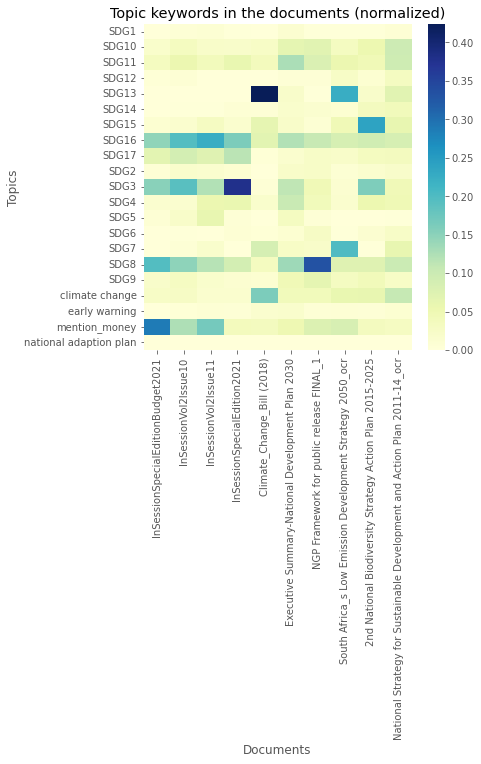

In [22]:
plt.figure(figsize=(6,6)) #16, 6
ax = sns.heatmap(normed_by_col_sum,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("Documents")
plt.ylabel("Topics")
title = ("Topic keywords in the documents (normalized)")
plt.title(title)
file_name=(title + (' some docs SA.png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

## Can use clustering of the heatmap results to see how documents that are related by source or time cluster by the topics and ndcs present within them

<Figure size 432x432 with 0 Axes>

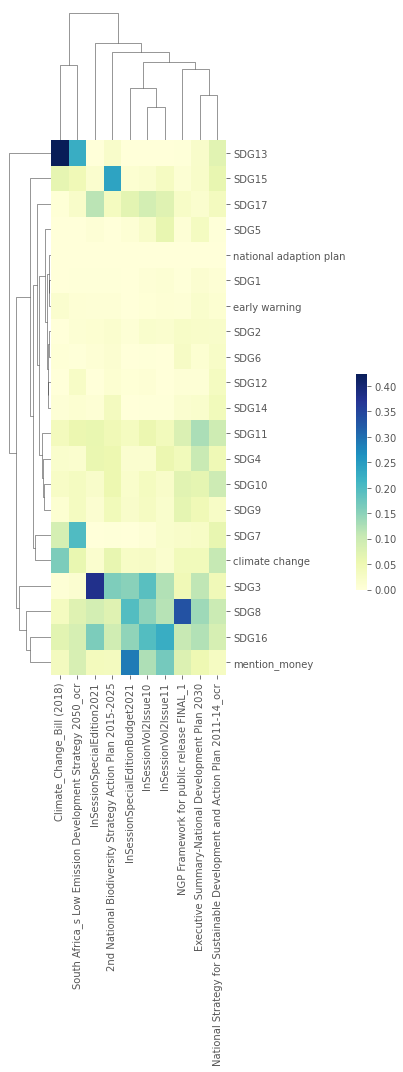

In [30]:
plt.figure(figsize=(6, 6))
ax = sns.clustermap(normed_by_col_sum,
                 #annot=True,
                 cbar_pos=(1.0, .45, .03, .2),
                 cmap="YlGnBu", 
                 xticklabels=1, 
                 yticklabels=1, 
                 figsize=(5, 15))
#plt.xlabel("Documents")
#plt.ylabel("SDG Topics")
title = ("Distribution of topic and NDC keywords in the documents (normalized)")
#plt.title(title)
file_name=(title + (' clustermap 10 docs SA v2.png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

## If using the embedding/correlator on the documents, a slightly different version of the pipeline is used: 

In [10]:
#if using Johnathan's fuzzy search:
#doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.txt'
#doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

max_word_length=25
corpus_summary_df = pd.DataFrame()
count = 1
for i in range(0, len(policy_doc_df[:10])):
    doc_name = policy_doc_df.iloc[i]['policy_doc_name_clean']
    doc_path = policy_doc_df.iloc[i]['policy_doc_paths']
    tokens, token_list, sentences, filtered_tokens, document_text, ndc_dict_corr, ndc_idx_df, ndc_summary_df, df_sdg, doc_summary_sdg_df, doc_summary_df = run_nlp_pipeline_no_lemma_ndc_corr(doc_name, doc_path, ndc_dict, max_word_length) 
    print(ndc_idx_df.NDC.value_counts()) 
    if count == 1: 
        corpus_summary_df = doc_summary_df
        total = doc_summary_df[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
        count += 1
    else: 
        corpus_summary_df_for_merge = doc_summary_df
        total = doc_summary_df[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
        corpus_summary_df = corpus_summary_df.merge(corpus_summary_df_for_merge, how="outer", left_index=True, right_index=True)
        count += 1

InSessionSpecialEditionBudget2021 ../../selected_policy_tracking_docs/SouthAfrica/InSession Parliament_s monthly magazine/TXT/InSessionSpecialEditionBudget2021.txt
These are some of the filtered tokens:  parliament republic south africa www.parliament.gov.za parliamentofrsa official newspaper parliament republic


NameError: name 'NGramCorrelateSpacy' is not defined

### Make a df and initial representation of the data with the correlation/ngram method for finding NDC words

In [ ]:
corpus_summary_df = corpus_summary_df.fillna(0)
corpus_summary_df_corr = corpus_summary_df
corpus_summary_df_corr.head()

#output_name = '../../outputs/SA_corr_matching_NDC_SDGs_10_doc_corpus_df.txt'
#corpus_summary_df.to_csv(output_name, sep='\t')

normed_by_col_sum_corr = corpus_summary_df_corr.div(corpus_summary_df_corr.sum(axis=0), axis=1).round(3)
#sorted_df_corr = normed_by_col_sum_corr.T.sort_values(by=['climate change'], ascending=False)
sorted_df_corr = normed_by_col_sum_corr.T.sort_values(by=['Fairness, equity, ambition'], ascending=False)
normed_by_col_sum_corr.head()

plt.figure(figsize=(8, 6)) #16, 6
ax = sns.heatmap(sorted_df_corr,
                 #annot=True, #fmt="d", 
                 cmap="YlGnBu")
#plt.xlabel("Documents")
#plt.ylabel("Topics")
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
title = ("NDC and custom topic keywords in the sorted documents")
plt.title(title)
file_name=(title + (' (with correlated NDCs).png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()